In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np

# Fetch dataset 
adult = fetch_ucirepo(id=2) 

# Data (as pandas dataframes) 
X = adult.data.features 
y = adult.data.targets 

# 1. First filter missing values from features
columns_to_check = ['workclass', 'native-country', 'occupation']
mask = (~X[columns_to_check].isin(['?']) & ~X[columns_to_check].isna()).all(axis=1)
filtered_X = X[mask].copy()
filtered_y = y[mask].copy()

# 2. Then clean the income column in the filtered data
filtered_y['income'] = filtered_y['income'].str.rstrip('.')

/var/folders/xq/_jsjc37x68149b8yz2n4q26w0000gn/T/ipykernel_4282/3903261595.py:76: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex',
/var/folders/xq/_jsjc37x68149b8yz2n4q26w0000gn/T/ipykernel_4282/3903261595.py:84: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex',


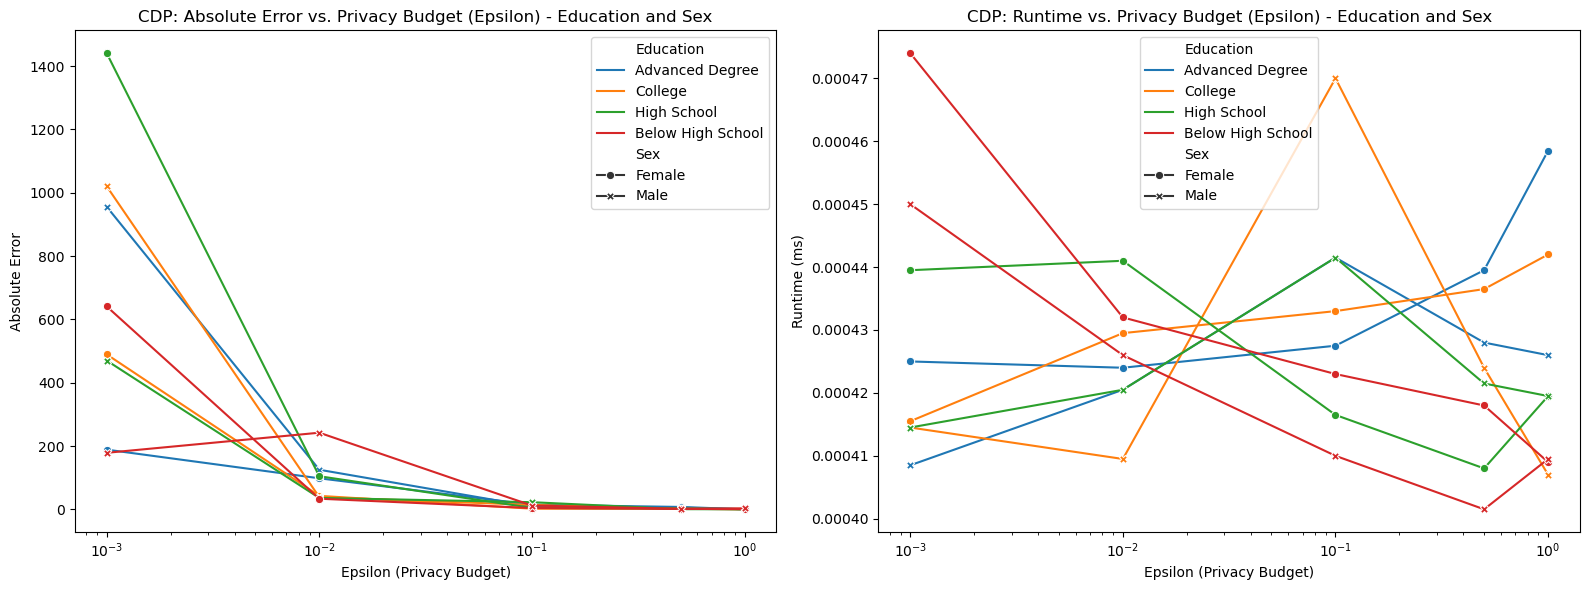

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Simplify education levels
def simplify_education(edu):
    if edu in ['Doctorate', 'Masters', 'Prof-school']:
        return 'Advanced Degree'
    elif edu in ['Bachelors', 'Assoc-acdm', 'Assoc-voc']:
        return 'College'
    elif edu in ['HS-grad', 'Some-college']:
        return 'High School'
    else:
        return 'Below High School'

# Add simplified education column
combined_df['education_level'] = combined_df['education'].apply(simplify_education)

# Define privacy budgets (adjusted to match your request)
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results
results = []
np.random.seed(42)
education_levels = ['Advanced Degree', 'College', 'High School', 'Below High School']
sex_categories = ['Female', 'Male']
income_categories = ["<=50K", ">50K"]

for edu_level in education_levels:
    for sex in sex_categories:
        subset = combined_df[(combined_df['education_level'] == edu_level) & 
                             (combined_df['sex'] == sex)]
        
        for epsilon in epsilon_values:
            for income in income_categories:
                true_count = len(subset[subset['income'] == income])
                dp_count = laplace_mechanism(true_count, epsilon)
                runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
                abs_error = abs(true_count - dp_count)
                
                results.append({
                    'Education': edu_level,
                    'Sex': sex,
                    'Epsilon': epsilon,
                    'Income': income,
                    'True Count': true_count,
                    'Absolute Error': abs_error,
                    'Runtime (ms)': round(runtime, 6)
                })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers (no confidence intervals)
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex', 
             markers=True, dashes=False, data=results_df, ax=ax1, ci=None)
ax1.set_title('CDP: Absolute Error vs. Privacy Budget (Epsilon) - Education and Sex')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers (no confidence intervals)
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex', 
             markers=True, dashes=False, data=results_df, ax=ax2, ci=None)
ax2.set_title('CDP: Runtime vs. Privacy Budget (Epsilon) - Education and Sex')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

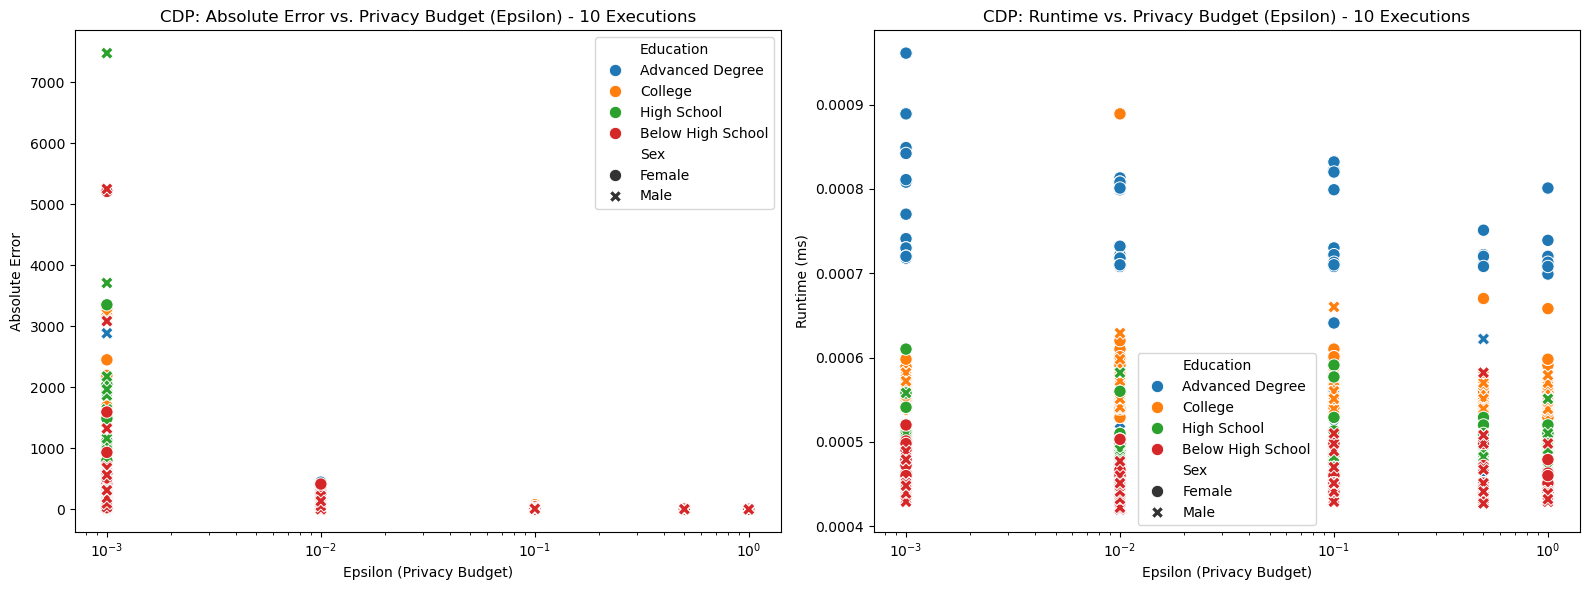

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Laplace mechanism for differential privacy
def laplace_mechanism(count, epsilon, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale)
    return max(0, int(round(count + noise)))

# Measure runtime
def measure_runtime(func, count, epsilon, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(count, epsilon)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Define privacy budgets and number of executions
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]
num_executions = 10

# Calculate results for multiple executions
results = []
np.random.seed(42)
education_levels = ['Advanced Degree', 'College', 'High School', 'Below High School']
sex_categories = ['Female', 'Male']
income_categories = ["<=50K", ">50K"]

for edu_level in education_levels:
    for sex in sex_categories:
        subset = combined_df[(combined_df['education_level'] == edu_level) & 
                             (combined_df['sex'] == sex)]
        
        for income in income_categories:
            true_count = len(subset[subset['income'] == income])
            
            for epsilon in epsilon_values:
                # Run 10 independent executions
                for execution in range(num_executions):
                    dp_count = laplace_mechanism(true_count, epsilon)
                    runtime = measure_runtime(laplace_mechanism, true_count, epsilon)
                    abs_error = abs(true_count - dp_count)
                    
                    results.append({
                        'Education': edu_level,
                        'Sex': sex,
                        'Epsilon': epsilon,
                        'Income': income,
                        'True Count': true_count,
                        'DP Count': dp_count,
                        'Absolute Error': abs_error,
                        'Runtime (ms)': round(runtime, 6),
                        'Execution': execution + 1
                    })

results_df = pd.DataFrame(results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex',
                data=results_df, s=80, ax=ax1)  # s controls the dot size
ax1.set_title('CDP: Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex',
                data=results_df, s=80, ax=ax2)  # s controls the dot size
ax2.set_title('CDP: Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()

/var/folders/xq/_jsjc37x68149b8yz2n4q26w0000gn/T/ipykernel_4282/2921344551.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex',
/var/folders/xq/_jsjc37x68149b8yz2n4q26w0000gn/T/ipykernel_4282/2921344551.py:130: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex',


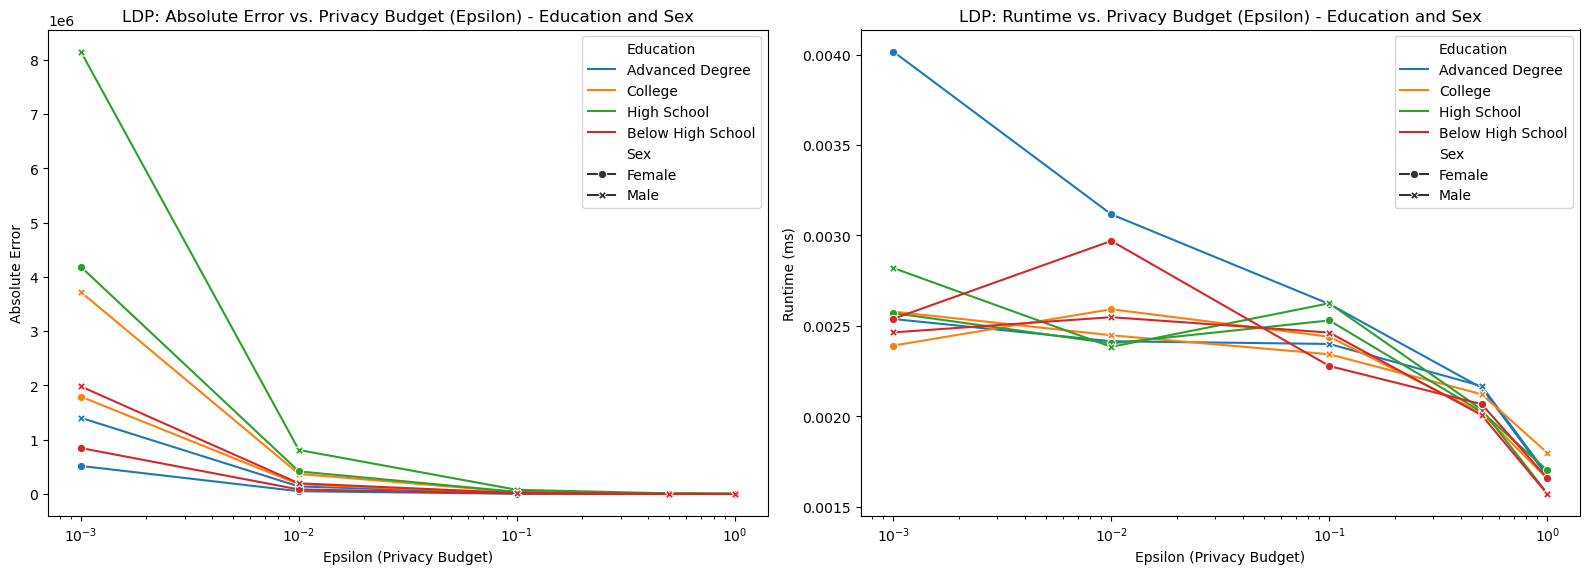

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Create a combined DataFrame for easier analysis
combined_df = pd.concat([filtered_X, filtered_y], axis=1)

# Simplify education levels
def simplify_education(edu):
    if edu in ['Doctorate', 'Masters', 'Prof-school']:
        return 'Advanced Degree'
    elif edu in ['Bachelors', 'Assoc-acdm', 'Assoc-voc']:
        return 'College'
    elif edu in ['HS-grad', 'Some-college']:
        return 'High School'
    else:
        return 'Below High School'

# Add simplified education column
combined_df['education_level'] = combined_df['education'].apply(simplify_education)

# Define epsilon values for Local Differential Privacy
epsilon_values_ldp = [0.001, 0.01, 0.1, 0.5, 1.0]

# Randomized Response mechanism for Local Differential Privacy
def randomized_response(value, epsilon, domain=["<=50K", ">50K"]):
    """
    Implements randomized response for Local Differential Privacy.
    
    Args:
        value: True value
        epsilon: Privacy parameter
        domain: Possible values
    
    Returns:
        Privatized value
    """
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # With probability p, keep the true value
    # With probability 1-p, sample uniformly from the domain
    if np.random.random() < p:
        return value
    else:
        return np.random.choice(domain)

# Function to measure runtime
def measure_ldp_runtime(func, value, epsilon, domain, num_iterations=1000):
    start_time = time.time()
    for _ in range(num_iterations):
        func(value, epsilon, domain)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Calculate results for LDP
ldp_results = []
np.random.seed(42)  # Set seed for reproducibility
education_levels = ['Advanced Degree', 'College', 'High School', 'Below High School']
sex_categories = ['Female', 'Male']
income_categories = ["<=50K", ">50K"]

for edu_level in education_levels:
    for sex in sex_categories:
        # Get subset of data for this education level and sex
        subset = combined_df[(combined_df['education_level'] == edu_level) & 
                            (combined_df['sex'] == sex)]
        total_records = len(subset)
        
        if total_records == 0:  # Skip if no records exist for this combination
            continue
            
        for epsilon in epsilon_values_ldp:
            # Measure average runtime
            sample_income = income_categories[0]
            runtime = measure_ldp_runtime(randomized_response, sample_income, epsilon, income_categories)
            
            # Apply randomized response to each individual
            privatized_incomes = []
            for _, row in subset.iterrows():
                privatized_income = randomized_response(row['income'], epsilon, income_categories)
                privatized_incomes.append(privatized_income)
            
            for income in income_categories:
                # Get true count for this income category in this group
                true_count = len(subset[subset['income'] == income])
                
                # Count of privatized responses for this income category
                privatized_count = privatized_incomes.count(income)
                
                # Calculate corrected estimate using the proper formula for binary randomized response
                p = np.exp(epsilon) / (1 + np.exp(epsilon))
                corrected_estimate = (privatized_count - total_records*(1-p)/2) / (2*p - 1)
                corrected_estimate = int(round(corrected_estimate))
                
                # Ensure the corrected estimate is non-negative
                corrected_estimate = max(0, corrected_estimate)
                
                # Calculate error metrics
                abs_error = abs(true_count - corrected_estimate)
                
                ldp_results.append({
                    'Education': edu_level,
                    'Sex': sex,
                    'Epsilon': epsilon,
                    'Income': income,
                    'True Count': true_count,
                    'LDP Count': privatized_count,
                    'Corrected Estimate': corrected_estimate,
                    'Absolute Error': abs_error,
                    'Runtime (ms)': round(runtime, 6)
                })

ldp_results_df = pd.DataFrame(ldp_results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error - Line plot with markers (no confidence intervals)
sns.lineplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax1, ci=None)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon) - Education and Sex')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale makes the epsilon values more evenly spaced

# Plot 2: Runtime - Line plot with markers (no confidence intervals)
sns.lineplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex', 
             markers=True, dashes=False, data=ldp_results_df, ax=ax2, ci=None)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon) - Education and Sex')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

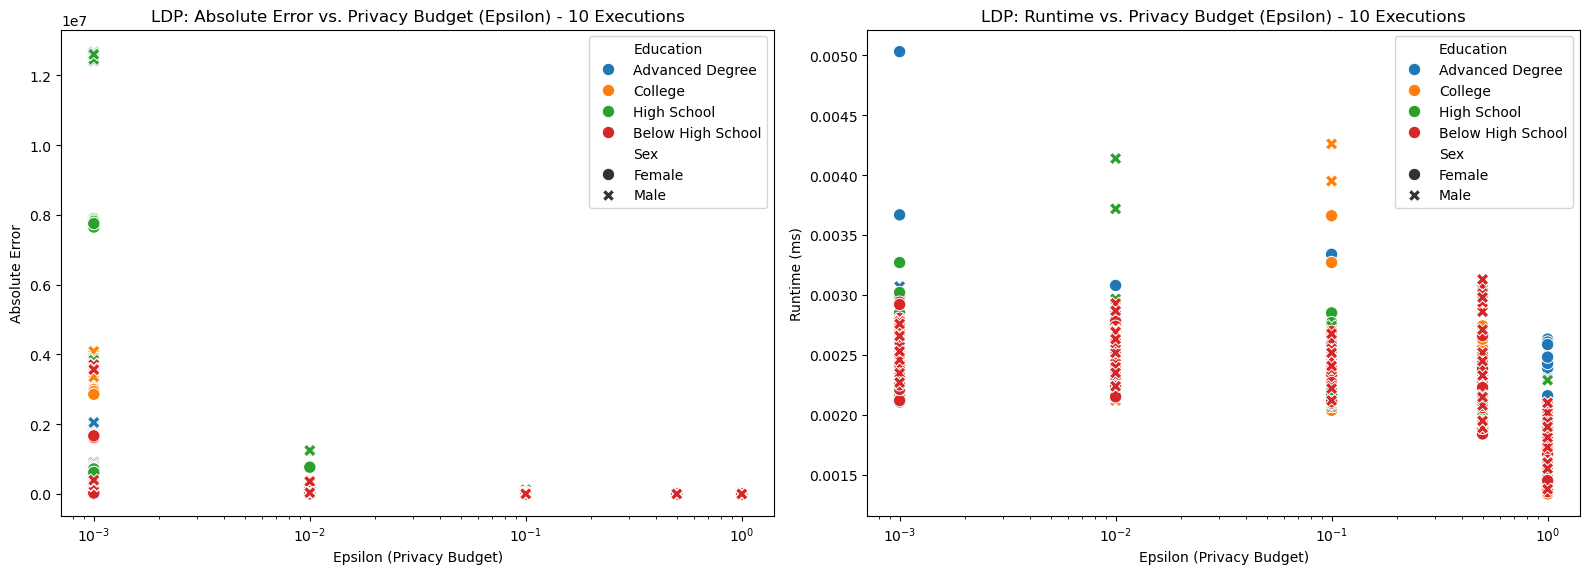

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Randomized Response mechanism for Local Differential Privacy
def randomized_response(value, epsilon, domain=["<=50K", ">50K"]):
    # Calculate probability of keeping true value
    p = np.exp(epsilon) / (1 + np.exp(epsilon))
    
    # With probability p, keep the true value
    # With probability 1-p, sample uniformly from the domain
    if np.random.random() < p:
        return value
    else:
        return np.random.choice(domain)

# Function to measure runtime
def measure_ldp_runtime(func, value, epsilon, domain, num_iterations=100):
    start_time = time.time()
    for _ in range(num_iterations):
        func(value, epsilon, domain)
    end_time = time.time()
    return ((end_time - start_time) / num_iterations) * 1000  # ms

# Define epsilon values and number of executions
epsilon_values = [0.001, 0.01, 0.1, 0.5, 1.0]
num_executions = 10

# Calculate results for LDP with multiple executions
ldp_results = []
education_levels = ['Advanced Degree', 'College', 'High School', 'Below High School']
sex_categories = ['Female', 'Male']
income_categories = ["<=50K", ">50K"]

for edu_level in education_levels:
    for sex in sex_categories:
        # Get subset of data for this education level and sex
        subset = combined_df[(combined_df['education_level'] == edu_level) & 
                            (combined_df['sex'] == sex)]
        total_records = len(subset)
        
        if total_records == 0:  # Skip if no records exist for this combination
            continue
            
        for income in income_categories:
            # Get true count for this income category
            true_count = len(subset[subset['income'] == income])
            
            for epsilon in epsilon_values:
                # Run multiple independent executions
                for execution in range(num_executions):
                    # Reset random seed for each execution to ensure independence
                    np.random.seed(42 + execution)
                    
                    # Measure runtime
                    sample_income = income_categories[0]
                    runtime = measure_ldp_runtime(randomized_response, sample_income, epsilon, income_categories)
                    
                    # Apply randomized response to each individual
                    privatized_incomes = []
                    for _, row in subset.iterrows():
                        privatized_income = randomized_response(row['income'], epsilon, income_categories)
                        privatized_incomes.append(privatized_income)
                    
                    # Count of privatized responses for this income category
                    privatized_count = privatized_incomes.count(income)
                    
                    # Calculate corrected estimate using the formula for binary randomized response
                    p = np.exp(epsilon) / (1 + np.exp(epsilon))
                    corrected_estimate = (privatized_count - total_records*(1-p)/2) / (2*p - 1)
                    corrected_estimate = int(round(corrected_estimate))
                    corrected_estimate = max(0, corrected_estimate)  # Ensure non-negative
                    
                    # Calculate absolute error
                    abs_error = abs(true_count - corrected_estimate)
                    
                    ldp_results.append({
                        'Education': edu_level,
                        'Sex': sex,
                        'Epsilon': epsilon,
                        'Income': income,
                        'True Count': true_count,
                        'Corrected Estimate': corrected_estimate,
                        'Absolute Error': abs_error,
                        'Runtime (ms)': round(runtime, 6),
                        'Execution': execution + 1
                    })

ldp_results_df = pd.DataFrame(ldp_results)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Absolute Error vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Absolute Error', hue='Education', style='Sex',
                data=ldp_results_df, s=80, ax=ax1)
ax1.set_title('LDP: Absolute Error vs. Privacy Budget (Epsilon) - 10 Executions')
ax1.set_xlabel('Epsilon (Privacy Budget)')
ax1.set_ylabel('Absolute Error')
ax1.set_xscale('log')  # Log scale for epsilon values

# Plot 2: Runtime vs. Epsilon - Scatter plot
sns.scatterplot(x='Epsilon', y='Runtime (ms)', hue='Education', style='Sex',
                data=ldp_results_df, s=80, ax=ax2)
ax2.set_title('LDP: Runtime vs. Privacy Budget (Epsilon) - 10 Executions')
ax2.set_xlabel('Epsilon (Privacy Budget)')
ax2.set_ylabel('Runtime (ms)')
ax2.set_xscale('log')  # Log scale for epsilon values

plt.tight_layout()
plt.show()